In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras

import sklearn.preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def get_dataset(directory):    
    merged_df = pd.DataFrame()
    for files in os.listdir(directory):
        df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
        df.dropna(inplace=True)
        merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    return merged_df

In [3]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables))

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [4]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    data_2d /= count
    return data_2d

In [5]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

In [6]:
def find_optimal_threshold(reconstruction_errors, y_true):
    best_threshold = 0.0
    best_f1 = 0.0

    thresholds = np.linspace(0.0, 1.0, num=1000)

    for threshold in thresholds:
        y_pred = (reconstruction_errors > threshold).astype(bool)

        current_f1 = f1_score(y_true.astype(bool), y_pred)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    return best_threshold, best_f1

In [7]:
merged_df = get_dataset('dataset_processed/splitted/2/train')
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

In [8]:
time_steps = 10
features = merged_data_np.shape[1]   
latent_dim = 32

In [9]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(merged_data_np)

merged_data_np_scaled = scaler.transform(merged_data_np)

pickle.dump(scaler, open('StandardScaler.pkl', 'wb'))

In [10]:
merged_data_np_3d = convert_time_window(merged_data_np_scaled, time_steps)

In [11]:
merged_data_np_3d.shape

(536753, 10, 3)

In [12]:
# Generator (Autoencoder with Encoder1 and Decoder)
def build_generator():
    inputs = keras.layers.Input(shape=(time_steps, features))
    
    # Encoder 1 (LSTM layers + Fully Connected Layers)
    x = keras.layers.LSTM(128, return_sequences=True)(inputs)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Latent representation (z)
    latent = keras.layers.Dense(latent_dim, activation='relu')(x)

    # Decoder (Symmetrical to Encoder 1)
    x = keras.layers.Dense(64)(latent)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dense(time_steps * features)(x)
    outputs = keras.layers.Reshape((time_steps, features))(x)
    
    model = keras.models.Model(inputs, outputs, name="Generator")
    return model


# Discriminator (used to classify real vs fake)
def build_discriminator():
    inputs = keras.layers.Input(shape=(time_steps, features))
    
    x = keras.layers.LSTM(128, return_sequences=True)(inputs)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Flatten and classify real vs fake
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.models.Model(inputs, x, name="Discriminator")
    return model

In [13]:
# Define loss functions
def generator_loss(fake_output, reconstructed_input, real_latent, reconstructed_latent, lambdas):
    bce_loss = keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Reconstruction loss (input space, L1 loss)
    lx = tf.reduce_mean(tf.abs(reconstructed_input - real_latent))
    
    # Latent space reconstruction loss (L2 loss)
    lz = tf.reduce_mean(tf.square(reconstructed_latent - real_latent))
    
    # Adversarial loss (Binary Crossentropy)
    adversarial_loss = bce_loss(tf.ones_like(fake_output), fake_output)
    
    # Combine losses
    loss = lambdas[0] * lx + lambdas[1] * lz + lambdas[2] * adversarial_loss
    return loss


def discriminator_loss(real_output, fake_output):
    bce_loss = keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Binary crossentropy loss for real and fake samples
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    
    # Total discriminator loss
    return real_loss + fake_loss

In [14]:
# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)

# Placeholders for real and fake inputs
real_data = keras.layers.Input(shape=(time_steps, features))
fake_data = generator(real_data)

# Discriminator training
real_output = discriminator(real_data)
fake_output = discriminator(fake_data)

In [15]:
@tf.function
def train_step(real_data):
    # Latent vectors for reconstruction
    real_latent = generator(real_data)
    
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake data
        fake_data = generator(real_data)
        
        # Discriminator outputs
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)
        
        # Latent space reconstruction
        reconstructed_latent = generator(fake_data)
        
        # Calculate losses
        gen_loss = generator_loss(fake_output, fake_data, real_latent, reconstructed_latent, lambdas=[0.2, 0.1, 0.7])
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Update gradients
    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [16]:
# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for real_data in dataset:
            gen_loss, disc_loss = train_step(real_data)
        
        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')

# Anomaly score and labeling
def compute_anomaly_score(real_data):
    fake_data = generator.predict(real_data)
    
    # Latent space reconstruction loss
    latent_real = generator(real_data)
    latent_fake = generator(fake_data)
    
    anomaly_score = np.mean(np.square(latent_real - latent_fake), axis=1)
    
    return anomaly_score

# def label_data(anomaly_score, thresholds):
#     labels = np.zeros_like(anomaly_score)
#     labels[anomaly_score < thresholds[0]] = 0  # "Good"
#     labels[(anomaly_score >= thresholds[0]) & (anomaly_score < thresholds[1])] = 1  # "Watching"
#     labels[(anomaly_score >= thresholds[1]) & (anomaly_score < thresholds[2])] = 2  # "Warning"
#     labels[anomaly_score >= thresholds[2]] = 3  # "Fault"
#     return labels

# # Model Evaluation
# def evaluate_model(real_data, true_labels, thresholds):
#     # Compute anomaly scores
#     anomaly_scores = compute_anomaly_score(real_data)
    
#     # Label data based on thresholds
#     predicted_labels = label_data(anomaly_scores, thresholds)
    
#     # Calculate evaluation metrics
#     precision = precision_score(true_labels, predicted_labels, average='weighted')
#     recall = recall_score(true_labels, predicted_labels, average='weighted')
#     f1 = f1_score(true_labels, predicted_labels, average='weighted')
#     cm = confusion_matrix(true_labels, predicted_labels)
    
#     print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(cm)

In [17]:
# Sample dataset and training example
train_data = merged_data_np_3d
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(32)

In [18]:
# Train the model
train(train_dataset, epochs=10)

c:\Users\farra\anaconda3\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 0.45279908180236816, Disc Loss: 1.5207252502441406
Epoch 2, Gen Loss: 0.4675253927707672, Disc Loss: 1.4082858562469482
Epoch 3, Gen Loss: 0.48224130272865295, Disc Loss: 1.3940682411193848
Epoch 4, Gen Loss: 5.453711032867432, Disc Loss: 0.0005041113472543657
Epoch 5, Gen Loss: 13.330048561096191, Disc Loss: 3.501121881299696e-08
Epoch 6, Gen Loss: 17.846107482910156, Disc Loss: 9.16796150107757e-09
Epoch 7, Gen Loss: 17.771203994750977, Disc Loss: 8.481889857137048e-09
Epoch 8, Gen Loss: 17.169925689697266, Disc Loss: 7.811036262239668e-09
Epoch 9, Gen Loss: 17.8572940826416, Disc Loss: 7.140829261231829e-09
Epoch 10, Gen Loss: 26.032379150390625, Disc Loss: 6.6587486635683035e-09


In [20]:
generator.save("generator_lstm_gan_10.h5")
discriminator.save("discriminator_lstm_gan_10.h5")

In [21]:
gener = keras.models.load_model("generator_lstm_gan_10.h5")

In [22]:
merged_df_test = get_dataset('dataset_processed/splitted/2/test')
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [27]:
scaler_test = pickle.load(open('StandardScaler.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np, 10)

In [28]:
test_data = merged_data_test_np_3d
fake_data = gener.predict(test_data)


3439/3439 [==============================] - 15s 4ms/step


In [31]:
fake_data_2d = inverse_convert_time_window(fake_data)

In [41]:
scalerrr = sklearn.preprocessing.StandardScaler()
fake_data_2d_scaled = scalerrr.fit_transform(fake_data_2d)

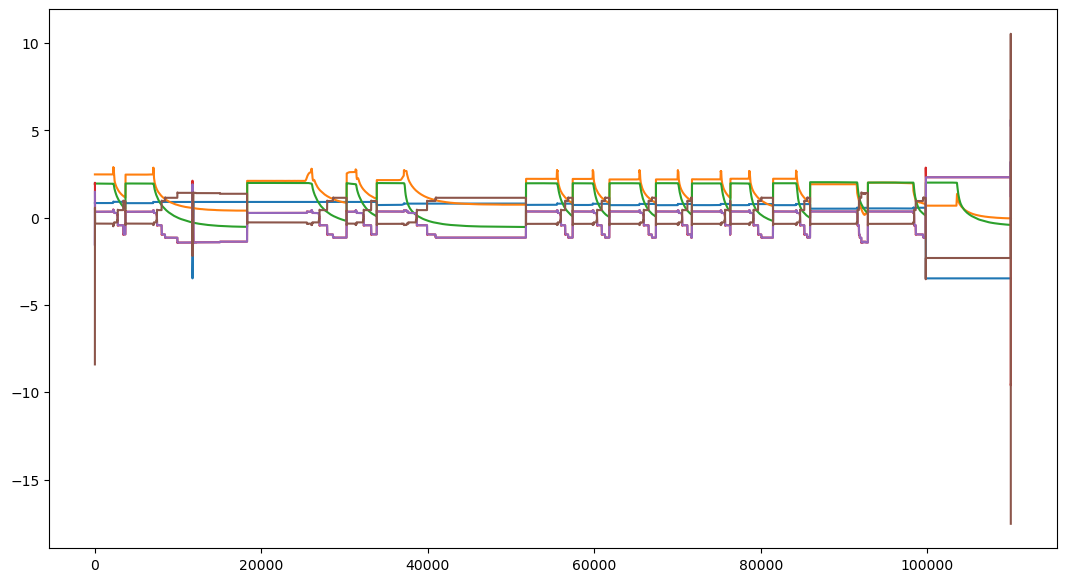

In [44]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(fake_data_2d_scaled)
plt.show()

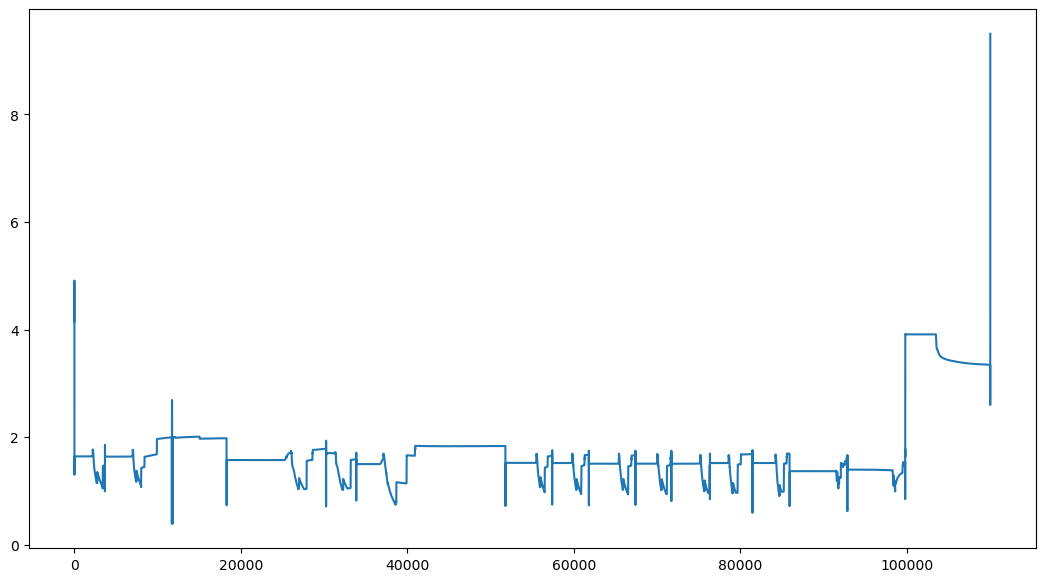

In [46]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, fake_data_2d_scaled)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(fake_data_2d_scaled)
plt.show()

In [28]:

# Latent space reconstruction loss
latent_real = generator(test_data)
latent_fake = generator(fake_data)

anomaly_score = np.mean(np.square(latent_real - latent_fake), axis=1)


In [ ]:

# Evaluate the model (replace `true_labels` with actual labels)
true_labels = np.random.randint(0, 4, size=1000)
evaluate_model(train_data, true_labels, thresholds=[0.2, 0.5, 0.7])